In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report


# Load and clean data
df = pd.read_csv('creditcard.csv')

# View data
print(df.head(4))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0

In [24]:
# Get shape
print(df.shape)

(284807, 31)


In [25]:
# 1. Data Cleaning and Pre-processing

# Get details of data
print(df.info())

# Check for missing data
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [26]:
# Check for blank rows
total_blanks = (df.astype(str).apply(lambda col: col.str.strip() == "")).sum().sum()
print(total_blanks)

0


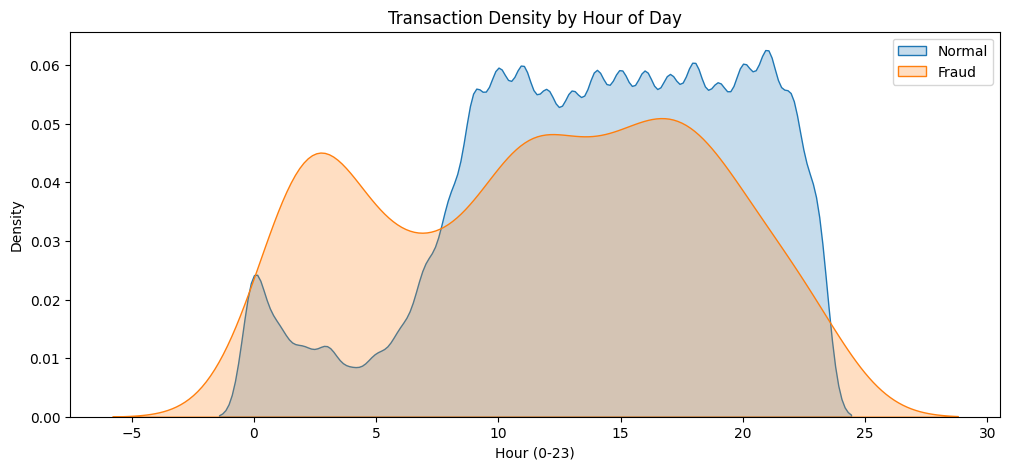

In [27]:
# Time Analysis
# Feature Engineering: Extract Hour before scaling
df['Hour'] = (df['Time'] // 3600) % 24

# Time Analysis Visualization
plt.figure(figsize=(12,5))
sns.kdeplot(df[df['Class'] == 0]['Hour'], label='Normal', fill=True)
sns.kdeplot(df[df['Class'] == 1]['Hour'], label='Fraud', fill=True)
plt.title('Transaction Density by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.legend()
plt.show()

In [28]:
# Scale Time and Amount with Robust Scaler (less prone to outliers)

from sklearn.preprocessing import RobustScaler

# Initialize the Scaler
rob_scaler = RobustScaler()

# Create new columns for scaled values
df['scaled_amount'] =  rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop the original unscaled columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Inspect few rows to verify
print(df[['scaled_amount', 'scaled_time']].head())

   scaled_amount  scaled_time
0       1.783274    -0.994983
1      -0.269825    -0.994983
2       4.983721    -0.994972
3       1.418291    -0.994972
4       0.670579    -0.994960


No Frauds: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


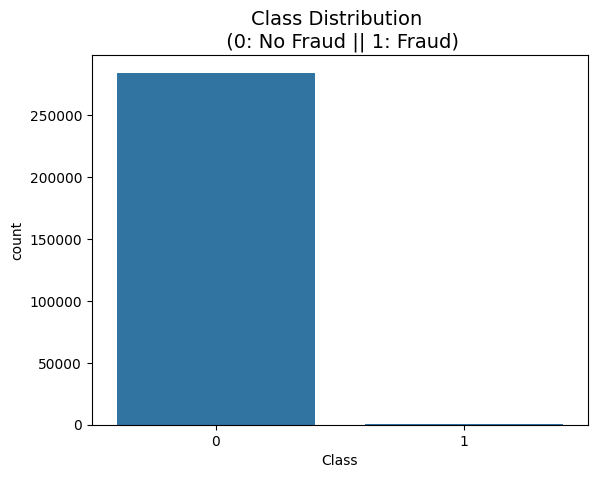

In [29]:
# 2. Analyzing the Class Imbalance

# Check the distribution of the Class column
print('No Frauds:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# Visualize the imbalance
sns.countplot(x='Class', data=df)
plt.title('Class Distribution \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()  

In [30]:
# Properly split data to prevent leaking due to massive imbalance

# Define features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify
print("Fraud ratio in Training set:", y_train.value_counts(normalize=True)[1])
print("Fraud ration in Test set:", y_test.value_counts(normalize=True)[1])

Fraud ratio in Training set: 0.001729245759178389
Fraud ration in Test set: 0.0017204452090867595


In [31]:
# 1. Combine them into one DataFrame
test_data_with_labels = pd.concat([X_test, y_test], axis=1)

# 2. Save it to a CSV in your project folder
test_data_with_labels.to_csv('test_data.csv', index=False)

print(f"Success! Saved {test_data_with_labels.shape[0]} rows to test_data.csv")

Success! Saved 56962 rows to test_data.csv


In [32]:
# Add baseline model to compare performance

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model without any weight adjustments
base_model = LogisticRegression(max_iter=1000)
base_model.fit(X_train, y_train)

# Make predictions
y_pred = base_model.predict(X_test)

# Evaluate
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Accuracy Score: 0.9992

--- Confusion Matrix ---
[[56851    13]
 [   34    64]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [33]:
# Initialize logistic Regression with class_weight

weighted_model = LogisticRegression(max_iter=1000, class_weight={0: 1, 1:500})
weighted_model.fit(X_train, y_train)

# Predictions
y_weighted_pred = weighted_model.predict(X_test)

# Evaluation
print("--- Weighted Confusion Matrix ---")
print(confusion_matrix(y_test, y_weighted_pred))
print("\n--- Weighted Classification Report ---")
print(classification_report(y_test, y_weighted_pred))

--- Weighted Confusion Matrix ---
[[55582  1282]
 [    9    89]]

--- Weighted Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [34]:
# Train an XGBoost model

# Calculate the ratio
ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])

xmodel = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    scale_pos_weight=ratio, # cost-sensitive part
    random_state=42

)

# Fit
xmodel.fit(X_train, y_train)

# Predict
y_xmodel_pred =  xmodel.predict(X_test)

#Evaluation
print("--- XGBoost Confusion Matrix ---")
print(confusion_matrix(y_test, y_xmodel_pred))
print("\n--- XGBoost Classification Report ---")
print(classification_report(y_test, y_xmodel_pred))

--- XGBoost Confusion Matrix ---
[[56853    11]
 [   15    83]]

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [35]:
# Data-Level Balancing (SMOTE + Tomek Links)

from imblearn.combine import SMOTETomek
from collections import Counter

# Initialize SMOTE + Tomek Links - this cleans overlapping boundary between classes
smt = SMOTETomek(random_state=42)

# Fit and resample only the training data
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

print(f"Original training class distribution: {Counter(y_train)}")
print(f"Resampled training class distribution: {Counter(y_resampled)}")

Original training class distribution: Counter({0: 227451, 1: 394})
Resampled training class distribution: Counter({0: 227451, 1: 227451})


In [36]:
# Train an XGBoost model with resampled data

xmodel_resampled = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    random_state=42

)

# Fit
xmodel_resampled.fit(X_resampled, y_resampled)

# Predict on the original X_test
y_resampled_pred = xmodel_resampled.predict(X_test)

# Evaluation
print("--- XGBoost (SMOTE+Tomek) Confusion Matrix ---")
print(confusion_matrix(y_test, y_resampled_pred))
print("\n--- XGBoost (SMOTE+Tomek) Classification Report ---")
print(classification_report(y_test, y_resampled_pred))

--- XGBoost (SMOTE+Tomek) Confusion Matrix ---
[[56821    43]
 [   12    86]]

--- XGBoost (SMOTE+Tomek) Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.67      0.88      0.76        98

    accuracy                           1.00     56962
   macro avg       0.83      0.94      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [37]:
# Cost-Benefit Matrix & Threshold Optimization

# Financial Impact Analysis
def analyze_financial_impact(y_true, y_pred, scaled_amounts):
    #Missed Fraud (False Negative)
    missed_indices = (y_true == 1) & (y_pred == 0)
    total_stolen = scaled_amounts[missed_indices].sum()

    # False Alarm (False Positive)
    alarm_indices = (y_true == 0) & (y_pred == 1)
    admin_cost = alarm_indices.sum() * 1.0

    # Caught Fraud (True Positive)
    caught_indices = (y_true == 1) & (y_pred == 1)
    money_saved = scaled_amounts[caught_indices].sum()

    return total_stolen, admin_cost, money_saved

stolen, admin, saved = analyze_financial_impact(y_test, y_resampled_pred, X_test['scaled_amount'])

print(f" Financial Report (Standard 0.5 Threshold):")
print (f" Total Stolen (Missed): {stolen:.2f}")
print(f" Total Admin Cost: {admin:.2f}")
print(f" Total Money Saved: {saved:.2f}")
print(f" Net Model Value: {saved - admin:.2f}")

 Financial Report (Standard 0.5 Threshold):
 Total Stolen (Missed): 21.95
 Total Admin Cost: 43.00
 Total Money Saved: 96.66
 Net Model Value: 53.66


In [38]:
# Sliding Threshold Optimization - to lower threshold for high-vlaue transactions

# Sliding threshold logic
def get_sliding_threshold_prediction(probability, scaled_amount):
    # If the transaction is in the top tier of amounts, be more aggressive
    if scaled_amount > 5.0:
        threshold = 0.25 # Lower threshold = High sensitivity
    else: 
        threshold = 0.55 # Higher threshold = Reduce false alarms for small transactions
    return 1 if probability >= threshold else 0

# Apply to the test set
y_probs = xmodel_resampled.predict_proba(X_test)[:, 1]
y_sliding_pred = [get_sliding_threshold_prediction(p, a)
                  for p, a in zip(y_probs, X_test['scaled_amount'])]

print("\n--- Sliding Threshold Results ---")
print(confusion_matrix(y_test, y_sliding_pred))


--- Sliding Threshold Results ---
[[56821    43]
 [   12    86]]


In [39]:
# Check how many 'Big' transactions are actually in the test set
big_tx = X_test[X_test['scaled_amount'] > 5.0]
print(f"Number of transactions > 5.0 scaled amount: {len(big_tx)}")

Number of transactions > 5.0 scaled amount: 2777


In [40]:
import joblib

# Save the Model
joblib.dump(xmodel_resampled, 'fraud_model_final.pkl')

# Save the Scaler 
joblib.dump(rob_scaler, 'robust_scaler.pkl')

print("Files saved successfully! You can now run the simulation.")

Files saved successfully! You can now run the simulation.


In [45]:
# Real-Time Simulation
import time

model = joblib.load('fraud_model_final.pkl')
sclaer = joblib.load('robust_scaler.pkl')

def production_simulation(test_df, num_seconds=10):

    money_saved = 0
    frauds_caught = 0
    
    print(f"{'Time':<8} | {'Amount':<10} | {'Predicted':<10} | {'Prob':<6} | {'Threshold':<9} | {'Action'}")
    print("-" * 60)

    for i in range(num_seconds):
        # Use one random transaction to simulate a "live" event
        sample = test_df.sample(1)

        # Extract features
        # 'scaled amount' is used here because that's what our df contains
        current_amount = float(sample['scaled_amount'].iloc[0])
        features = sample.drop('Class', axis=1).values.reshape(1, -1)
        actual_label =sample['Class'].iloc[0]
                               

        # Get model probability
        prob = model.predict_proba(features)[0][1]

        # Apply sliding threshold logic
        threshold = 0.25 if current_amount > 5.0 else 0.55
        prediction = 1 if prob >= threshold else 0

        # Determine Action
        if prediction == 1:
            action = "🚨 BLOCK"
            if actual_label == 1:
                money_saved += current_amount
                frauds_caught += 1
        else: 
            action = "✅ ALLOW"

        timestamp = time.strftime("%H:%M:%S")
        print(f"{timestamp:<8} | {current_amount:>10.2f} | {prediction:<10} | {prob:.4f} | {threshold:<9} | {action}")
        time.sleep(1)
    
    print("-" * 60)
    print(f"TOTAL SAVED: {money_saved:.2f} units | FRAUDS CAUGHT: {frauds_caught}")
    
production_simulation(test_data_with_labels)

Time     | Amount     | Predicted  | Prob   | Threshold | Action
------------------------------------------------------------
22:19:49 |       1.09 | 0          | 0.0000 | 0.55      | ✅ ALLOW
22:19:50 |       0.11 | 0          | 0.0000 | 0.55      | ✅ ALLOW
22:19:51 |       0.50 | 0          | 0.0000 | 0.55      | ✅ ALLOW
22:19:52 |      -0.28 | 0          | 0.0001 | 0.55      | ✅ ALLOW
22:19:53 |       0.27 | 0          | 0.0000 | 0.55      | ✅ ALLOW
22:19:54 |      -0.29 | 0          | 0.0000 | 0.55      | ✅ ALLOW
22:19:55 |      -0.14 | 0          | 0.0011 | 0.55      | ✅ ALLOW
22:19:56 |      -0.28 | 0          | 0.0001 | 0.55      | ✅ ALLOW
22:19:57 |       0.02 | 0          | 0.0001 | 0.55      | ✅ ALLOW
22:19:58 |      -0.10 | 0          | 0.0000 | 0.55      | ✅ ALLOW
------------------------------------------------------------
TOTAL SAVED: 0.00 units | FRAUDS CAUGHT: 0


In [42]:
# Latency-Aware Simulation

import time

def production_simulation_v2(test_df, num_seconds=10):
    money_saved = 0
    frauds_caught = 0
    latencies = []
    
    print(f"{'Time':<8} | {'Amount':<10} | {'Pred':^6} | {'Prob':<6} | {'Latency':<8} | {'Action'}")
    print("-" * 75)

    for i in range(num_seconds):
        sample = test_df.sample(1)
        current_amount = float(sample['scaled_amount'].iloc[0])
        features = sample.drop('Class', axis=1).values.reshape(1, -1)
        actual_label = sample['Class'].iloc[0]

        # MEASURE LATENCY START 
        start_time = time.perf_counter()
        prob = model.predict_proba(features)[0][1]
        end_time = time.perf_counter()
        # -----------------------------
        
        latency_ms = (end_time - start_time) * 1000 # Convert to milliseconds
        latencies.append(latency_ms)

        threshold = 0.25 if current_amount > 5.0 else 0.55
        prediction = 1 if prob >= threshold else 0

        action = "🚨 BLOCK" if prediction == 1 else "✅ ALLOW"
        if prediction == 1 and actual_label == 1:
            money_saved += current_amount
            frauds_caught += 1

        timestamp = time.strftime("%H:%M:%S")
        print(f"{timestamp:<8} | {current_amount:>10.2f} | {prediction:^6} | {prob:.4f} | {latency_ms:>5.2f}ms | {action}")
        time.sleep(1)
    
    print("-" * 75)
    print(f"TOTAL SAVED: {money_saved:.2f} units | FRAUDS CAUGHT: {frauds_caught}")
    print(f"AVERAGE LATENCY: {sum(latencies)/len(latencies):.2f} ms")


production_simulation_v2(test_data_with_labels)

Time     | Amount     |  Pred  | Prob   | Latency  | Action
---------------------------------------------------------------------------
21:52:12 |      -0.29 |   0    | 0.0001 |  4.55ms | ✅ ALLOW
21:52:13 |      -0.29 |   0    | 0.0000 |  3.12ms | ✅ ALLOW
21:52:14 |      -0.10 |   0    | 0.0002 |  6.81ms | ✅ ALLOW
21:52:15 |       3.93 |   0    | 0.0044 |  2.39ms | ✅ ALLOW
21:52:16 |       0.58 |   0    | 0.0001 |  2.10ms | ✅ ALLOW
21:52:17 |       0.81 |   0    | 0.0000 |  2.67ms | ✅ ALLOW
21:52:18 |       0.11 |   0    | 0.0000 |  2.34ms | ✅ ALLOW
21:52:19 |       4.37 |   0    | 0.0001 |  2.29ms | ✅ ALLOW
21:52:20 |       0.61 |   0    | 0.0000 |  4.36ms | ✅ ALLOW
21:52:21 |       0.65 |   0    | 0.0040 |  3.97ms | ✅ ALLOW
---------------------------------------------------------------------------
TOTAL SAVED: 0.00 units | FRAUDS CAUGHT: 0
AVERAGE LATENCY: 3.46 ms


In [43]:
# Check the feature names the model was trained on
if hasattr(xmodel_resampled, "feature_names_in_"):
    print("Features expected by model:")
    print(list(xmodel_resampled.feature_names_in_)) # Fixed the extra " here
    print(f"\nTotal Count: {len(xmodel_resampled.feature_names_in_)}")
else:
    print(f"Model expects {xmodel_resampled.n_features_in_} features.")

Features expected by model:
[np.str_('V1'), np.str_('V2'), np.str_('V3'), np.str_('V4'), np.str_('V5'), np.str_('V6'), np.str_('V7'), np.str_('V8'), np.str_('V9'), np.str_('V10'), np.str_('V11'), np.str_('V12'), np.str_('V13'), np.str_('V14'), np.str_('V15'), np.str_('V16'), np.str_('V17'), np.str_('V18'), np.str_('V19'), np.str_('V20'), np.str_('V21'), np.str_('V22'), np.str_('V23'), np.str_('V24'), np.str_('V25'), np.str_('V26'), np.str_('V27'), np.str_('V28'), np.str_('Hour'), np.str_('scaled_amount'), np.str_('scaled_time')]

Total Count: 31
